In [1]:
%matplotlib inline

import numpy as np
import scipy
import copy

from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix, vstack
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import time

from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, operators, adaptive
from pyiga import algebra_cy, ieti_cy

from scipy.sparse.linalg import aslinearoperator as LinOp

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)

In [2]:
def consistency_split(MP, a, return_P=False):
    marked = []
    num_split = 0
    if return_P:
        P = scipy.sparse.identity(MP.nLocDofs)
    while True:
        for (p1,b1) in MP.mesh.L_intfs:
            if len(MP.mesh.L_intfs[(p1,b1)])==2:
                p2 = MP.mesh.L_intfs[(p1,b1)][0][0]
                if a[MP.mesh.patch_domains[p1]] + 1e-3 < a[MP.mesh.patch_domains[p2]]:
                    marked.append(p1)
        if len(marked)>0:
            num_split+=len(marked)
            if return_P:
                P = MP.h_refine({p:None for p in marked}, ref="rs", return_P=return_P, decoupled=True) @ P
            else:
                MP.h_refine({p:None for p in marked}, ref="rs", return_P=return_P, decoupled=True)
            marked=[]
        else:
            break
    print("Split {} additional patches due to consistency".format(num_split))
    if return_P:
        return P

In [3]:
def admissibility_split(MP, return_P=False):
    mapped = lambda x: 1 if x in (0, 1) else 0
    marked=[]
    num_split=0
    if return_P:
        P = scipy.sparse.identity(MP.N_ofs[-1])
    while True:
        for p in range(MP.mesh.numpatches):
            for b in range(4):
                kv = MP.mesh.kvs[p][mapped(b)]
                parameter_nodes = MP.mesh.boundaries(p)[1][b]
                C = bspline.collocation(kv,parameter_nodes).toarray()
                if C.shape[0]-np.linalg.matrix_rank(C)>0:
                    marked.append(p)
        if len(marked)>0:
            num_split+=len(marked)
            if return_P:
                P = MP.h_refine({p:None for p in marked}, ref="rs", return_P=return_P, decoupled=True) @ P
            else:
                MP.h_refine({p:None for p in marked}, ref="rs", return_P=return_P, decoupled=True)
            marked=[]
        else:
            break
    print("Split {} additional patches due to admissibility".format(num_split))
    if return_P:
        return P

In [4]:
class IetiMapper:
    def __init__(self, M, dir_data, neu_data=None, elim=False):
        self.mesh = M
        self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod(n) for n in self.n]
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        
        self.elim=bool(elim)

        self.P = {}
        self.intfs = set()
        self.L_intfs = {}

        for ((p1,bd1,s1),((p2,bd2,s2),flip)) in self.mesh.interfaces.items():
            if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
            
        B=[self.computeInterfaceJump(p1, bspline._parse_bdspec(bd1,2), s1, 
                                     p2, bspline._parse_bdspec(bd2,2), s2, flip) for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs.copy()]
        if len(B)!=0:
            self.B = scipy.sparse.vstack(B)

        for (p,b,_),(p2,b2,_),flip in self.intfs:
            if (p,b) not in self.L_intfs:
                self.L_intfs[(p,b)]=[(p2,b2)]
            else:
                self.L_intfs[(p,b)].append((p2,b2))

        kvs = self.mesh.kvs
        geos = self.mesh.geos

        self.dir_idx = dict()
        self.dir_vals = dict()
        self.free = [np.arange(self.N[p]) for p in range(self.nPatches)]

        for key in dir_data:
            for p,b in self.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], b, dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
            self.free[p] = np.setdiff1d(self.free[p],self.dir_idx[p],assume_unique=True)
            
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])
        self.global_free = np.setdiff1d(np.arange(self.N_ofs[-1]),self.global_dir_idx, assume_unique=True)

        self.corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True)+self.N_ofs[p] for p, kvs in enumerate(self.mesh.kvs)])

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.intfs], dtype=np.int32).T
        #     Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=10)
        #     self.Basis, self.N_ofs, self.N, B = ieti_cy.pyx_compute_decoupled_coarse_basis(Basis.tocsc(), self.N_ofs.astype(np.int32), p_intfs)
        
        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.nPatches)]
        nnz_per_col = self.B.getnnz(axis=0)
        # self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.skeleton = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.global_dir_idx)
        self.interior = np.setdiff1d(np.where(nnz_per_col == 0)[0], self.global_dir_idx)
        
        self.R_interior = self.nPatches*[None] ###TODO: without loops
        self.R_skeleton = self.nPatches*[None]
        self.R_interfaces = {}
        
        for p in range(self.nPatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior,:][:,self.free[p]]
            for b in range(4):
                if not any([(p,b) in self.mesh.outer_boundaries[key] for key in self.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=b,ravel=True)
                    mask_intf[interface_dofs[1:-1]] = True
                    mask_skeleton[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                        mask_skeleton[self.dir_idx[p]]=False

                    self.R_interfaces[(p,b)] = Id[mask_intf,:][:,self.free[p]]
            self.R_skeleton[p] = Id[mask_skeleton,:][:,self.free[p]]
            
    @property
    def nPatches(self):
        return self.mesh.numpatches

    @property
    def nLocDofs(self):
        return self.N_ofs[-1]

    @property
    def nLocDirichlet(self):
        return np.sum([len(d) for d in self.dir_idx])

    def assemble(self, a, f):
        if self.elim:
            A = [self.Basis.T @ assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) @ self.Basis for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [self.Basis.T @ assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        else:
            A = [assemble.assemble('a * inner(grad(u), grad(v)) * dx', kvs, a=a[self.mesh.patch_domains[k]], bfuns=[('u',1), ('v',1)], geo=geo) for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
            RHS = [assemble.assemble('f * v * dx', kvs, bfuns=[('v',1)], geo=geo, f=f[self.mesh.patch_domains[k]]).ravel() for k, ((kvs, geo),_) in enumerate(self.mesh.patches)]
        
        self.BCRestr = {p:assemble.RestrictedLinearSystem(A[p], RHS[p], (self.dir_idx[p],self.dir_vals[p])) for p in self.dir_idx}
        RHS = [rhs if p not in self.dir_idx else self.BCRestr[p].b for p, rhs in enumerate(RHS)]
        A = [a if p not in self.dir_idx else self.BCRestr[p].A for p, a in enumerate(A)]

        return A, RHS

    def ConstraintMatrices(self, redundant = False):
        eliminated_constraints = np.repeat(False, self.B.shape[0])
        B = self.B.tocsc()
        if not redundant:
            eliminated_constraints = ieti_cy.eliminate_corner_constraints(B.indptr.astype(np.int32), B.indices.astype(np.int32), B.data, *B.shape, 
                                                                          self.corners.astype(np.int32), len(self.corners)).astype(bool)

        B = self.B[:,self.global_free]

        eliminated_constraints = eliminated_constraints | (B.getnnz(1)==0)
        B = B[~eliminated_constraints,:]
        ofs = np.cumsum([0]+[len(x) for x in self.free])
        return [B[:,ofs[p]:ofs[p+1]] for p in range(self.nPatches)], eliminated_constraints

    def parametersort(self, a):
        D = np.array([a[key] for key in self.mesh.patch_domains.values()], dtype=float)
        ieti_cy.pyx_parametersort(self.B.indptr, self.B.indices, self.B.data, *self.B.shape, np.repeat(D,self.N))

    def computeInterfaceJump(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.sdim-1)*(False,)
        
        bkv1 = assemble.boundary_kv(kvs1, bdspec1)
        bkv2 = assemble.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = assemble.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = assemble.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([kv1<=kv2 for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([kv2<=kv1 for kv1, kv2 in zip(bkv1,bkv2)]):      
            self.intfs.remove(((p1,2*bdspec1[0][0]+bdspec1[0][1],s1),(p2,2*bdspec2[0][0]+bdspec2[0][1],s2),flip))
            self.intfs.add(((p2,2*bdspec2[0][0]+bdspec2[0][1],s2),(p1,2*bdspec1[0][0]+bdspec1[0][1],s1),flip))
            #switch variables so patch 1 is always coarse
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            match 2*b1[0]+b1[1]:
                case 0: side1='bottom'
                case 1: side1='top'
                case 2: side1='left'
                case 3: side1='right'
            match 2*b2[0]+b2[1]:
                case 0: side2='bottom'
                case 1: side2='top'
                case 2: side2='left'
                case 3: side2='right'
            raise AssertionError(f"Interface coupling not possible between patch {p1} on the {side1} side and patch {p2} on the {side2} side")
            
        #Prolongation operator  
        P = -scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make paramater to generate prolongation matrix as coo_matrix directly?
        #construct constraints for this interface
        data = np.concatenate([P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        return scipy.sparse.csr_matrix((data,(I,J)),(len(dofs2), self.N_ofs[-1]))
        
    def nodes_as_primals(self, dir_boundary=False):  ###TODO: cythonize(?)
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        deg = self.mesh.patches[0][0][0][0].p
        n = self.N_ofs[-1]
        loc_c = self.corners
        if not dir_boundary: loc_c = np.setdiff1d(loc_c, self.global_dir_idx, assume_unique=True) 
  
        idx = (self.B[:,loc_c].getnnz(1)>0) & (self.B.getnnz(1)==2)
        B = self.B[idx,:]
        #B = B[B.getnnz(1)==2,:]
        loc_c = np.unique(B.indices)
        if not dir_boundary: loc_c = np.setdiff1d(loc_c, self.global_dir_idx, assume_unique=True) 

        q = np.where(B.getnnz(0)>0)[0]
        R = scipy.sparse.coo_matrix((np.ones(len(q)),(np.arange(len(q)),q)),shape=(len(q),n)).tocsr()
        c_B = B@R.T
        c_B.eliminate_zeros()

        nodal_coeff = R.T@algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=10)
        #print(nodal_coeff)

        nodal_coeff += ieti_cy.identify_T_coefficients_from_corner_basis(nodal_coeff.indptr, nodal_coeff.indices, nodal_coeff.data, *nodal_coeff.shape,
                                                                         self.B.indptr,      self.B.indices,      self.B.data,       self.B.shape[0], deg)
        return nodal_coeff
        
    #def averages_as_primals(self):

    def completeDirichlet(self, U):
        return [self.BCRestr[p].complete(u) if p in self.BCRestr else u for p,u in enumerate(U)]

In [5]:
class PrimalSystem():
    def __init__(self, Prim):
        self.Prim = Prim
        self.nPrim = self.Prim.shape[1]

        self.Psi = scipy.sparse.csc_matrix((0,self.nPrim))
        self.A_prim = scipy.sparse.csr_matrix(2*(self.nPrim,))
        self.RHS_prim = np.zeros(self.nPrim)
        self.R = []
        self.eliminate_pointwise = False

    def incorporate_PrimalConstraints(self, A, B, RHS, IMap, eliminate_pointwise=False):
        self.eliminate_pointwise = eliminate_pointwise
        self.nLagrangeMultipliers = B[0].shape[0]
        
        if self.nPrim == 0:
            return A, B, RHS
        K = len(A)
        self.C=[]
        
        for p in range(K):
            c = (self.Prim[IMap.N_ofs[p]:IMap.N_ofs[p+1],:].T).tocsr()
            c.eliminate_zeros()
            jj = np.where((c.indptr[1:]-c.indptr[:-1])>0)[0]
            c = c[:,IMap.free[p]]
            c = c[jj,:]
            self.C.append(c)
            self.R.append(scipy.sparse.coo_matrix((np.ones(c.shape[0]),(np.arange(c.shape[0]),jj)),(c.shape[0],self.nPrim)))
            
        self.nPrimConstr = [c.shape[0] for c in self.C]

        mod_A = [scipy.sparse.bmat([[A[p],self.C[p].T],[self.C[p], None]]) for p in range(K)]
        mod_RHS = [np.concatenate([RHS[p],np.zeros(self.nPrimConstr[p])]) for p in range(K)]

        mod_B = [scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((self.nLagrangeMultipliers, self.nPrimConstr[p]))]) for p in range(K)]
        return mod_A, mod_B, mod_RHS, self.C
        
    # def compute_PrimalBasis(self, mod_A, mod_B, mod_RHS):
    #     #TODO: eliminate pointwise constraints if desired
    #     #if eliminate_pointwise:
        
    #     loc_solver=[solvers.make_solver(a, spd=True, symm=True) if self.nPrimConstr[i]==0 else solvers.make_solver(a, spd=False, symm=True) for i, a in enumerate(mod_A)]
    #     self.Psi = []
    #     Delta = []
    #     self.B_prim = scipy.sparse.csr_matrix((self.nLagrangeMultipliers,self.nPrim))
    #     for p in range(len(mod_A)):
    #         RHS = scipy.sparse.vstack([scipy.sparse.csr_matrix((loc_solver[p].shape[0]-self.nPrimConstr[p],self.nPrimConstr[p])), scipy.sparse.identity(self.nPrimConstr[p])]).toarray()
    #         sol = loc_solver[p]@RHS
    #         psi, delta = sol[:(-self.nPrimConstr[p]),], sol[(-self.nPrimConstr[p]):,]
    #         #if psi.ndim==1: psi=psi[:,None]
    #         #if delta.ndim==1: delta=delta[:,None]
    #         Delta.append(delta)
    #         #print(self.C[p]@psi)
    #         self.Psi.append(psi@self.R[p])
    #         self.A_prim -= self.R[p].T@scipy.sparse.csr_matrix(delta)@self.R[p]
    #         self.B_prim += mod_B[p][:,:-self.nPrimConstr[p]]@scipy.sparse.csr_matrix(self.Psi[-1])
    #         self.RHS_prim += self.Psi[-1].T@mod_RHS[p][:-self.nPrimConstr[p]]
    #     return loc_solver

    def compute_PrimalBasis(self, mod_A, mod_B, mod_RHS):
        self.Psi = []
        Delta = []
    
        A_prim = []
        B_prim = []
    
        loc_solvers = [
            solvers.make_solver(A, spd=bool(self.nPrimConstr[i] == 0), symm=True)
            for i, A in enumerate(mod_A)
        ]
    
        for p, solver in enumerate(loc_solvers):
            n_constr = self.nPrimConstr[p]
            n_total = solver.shape[0]
            n_free = n_total - n_constr
    
            # Build RHS: stacked [0; I]
            RHS = vstack([
                csr_matrix((n_free, n_constr)),
                identity(n_constr, format='csr')
            ])
    
            # Solve with dense RHS (assumed requirement of solver)
            sol = solver @ RHS.toarray()
            psi = sol[:n_free, :]
            delta = sol[n_free:, :]
    
            self.Psi.append(csr_matrix(psi @ self.R[p]))
            Delta.append(csr_matrix(delta))

            A_prim.append(self.R[p].T @ Delta[-1] @ self.R[p])
            B_prim.append(mod_B[p][:, :n_free] @ self.Psi[-1])
            self.RHS_prim += self.Psi[-1].T@mod_RHS[p][:-self.nPrimConstr[p]]
    
        # One-time sparse sum
        self.A_prim = -1*sum(A_prim)
        self.B_prim = sum(B_prim)
        #self.RHS_prim += sum(RHS_prim_contribs)
    
        return loc_solvers

    def distributePrimalSolution(self, u):
        u_prim = u[-1]
        return [u[p]+self.Psi[p]@u_prim for p in range(len(u)-1)]

    def PrimalSolution(self, u_prim):
        return [psi@u_prim for psi in self.Psi]

    #def sanity_check():
        

In [6]:
class IetiSystem():
    def __init__(self, A, B ,RHS, N, loc_solver = None, spd=False, symm=False):
        self.A = A
        self.B = B
        self.RHS = RHS
        self.N = N

        self.sanity_check()

        if loc_solver:
            assert len(loc_solver)==len(A), 'amount of local solvers does not match amount of local system matrices!'
            self.loc_solver=loc_solver
        else:
            self.loc_solver = [solvers.make_solver(a, spd=spd, symm=symm) for a in self.A]

        self.K = len(A)
        self.nLagrangeMultipliers = self.B[0].shape[0]

    def SaddlePointSystem(self, format='csr'):
        B = scipy.sparse.hstack(self.B)
        return scipy.sparse.bmat([[scipy.sparse.block_diag(self.A),B.T],[B,None]], format=format)

    def RHSforSaddlePointSystem(self):
        return np.concatenate(self.RHS+[np.zeros(self.nLagrangeMultipliers)])

    def SchurComplement(self, as_matrix=False):
        F = operators.SumOperator([LinOp(self.B[p])@self.loc_solver[p]@LinOp(self.B[p].T) for p in range(self.K)])
        if as_matrix:
            return F@np.identity(F.shape[1])
        return F

    def RHSforSchurComplement(self):
        return np.sum([self.B[p]@(self.loc_solver[p]@self.RHS[p]) for p in range(self.K)], axis=0)

    def constructSolutionFromLagrangeMultipliers(self, lam):
        return [(self.loc_solver[p]@(self.RHS[p]-self.B[p].T@lam))[:self.N[p]] for p in range(self.K)]
        
    def sanity_check(self):
        assert len(self.A)==len(self.B)==len(self.RHS), 'Length of input data incompatible!'
        K = len(self.A)
        assert np.all([self.B[0].shape[0]==self.B[p].shape[0] for p in range(K)]), 'Constraint matrices have incompatible number of constraints!'
        assert np.all([self.A[p].shape[0]==self.A[p].shape[1] for p in range(K)]), 'Local system matrices are not square!'
        assert np.all([self.B[p].shape[1] == self.A[p].shape[1] for p in range(K)]), 'Constraint matrices have incompatible dimension!'
        assert np.all([self.A[p].shape[0]==len(self.RHS[p]) for p in range(K)]), 'Local rhs vectors have incompatible dimension!'

In [7]:
class ScaledDirichletPreconditioner():
    def __init__(self, A ,B, IMap):
        self.A = A
        self.IMap = IMap
        self.K   = len(B)

        self.B = [B[p]@IMap.R_skeleton[p].T for p in range(self.K)]
        self.B_full   = scipy.sparse.hstack(self.B, format='csr')
        self.BN  = np.array([IMap.R_skeleton[p].shape[0] for p in range(self.K)]) 
        self.BN_ofs = np.cumsum(np.r_[0,self.BN])

        self.D = []
        self.S = [LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_skeleton[p].T) - 
                  LinOp(IMap.R_skeleton[p]@A[p]@IMap.R_interior[p].T)
                  @solvers.make_solver(IMap.R_interior[p]@A[p]@IMap.R_interior[p].T, spd=True)
                  @LinOp(IMap.R_interior[p]@A[p].T@IMap.R_skeleton[p].T) for p in range(self.K)]

    def SchurMatrices(self): #for large number of degrees of freedom not feasible
        return [s@np.eye(s.shape[0]) for s in self.S]

    def setupMultiplicityScaling(self):
        d = ieti_cy.pyx_multiplicity_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 
        
    # def setupConstraintScaling(self):
    #     d = ieti_cy.pyx_constraint_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
    #     self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 

    def setupWeightScaling(self):
        d = ieti_cy.pyx_weight_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 
        
    def setupCoefficientScaling(self, a):  ###TODO: cythonize
        self.D = [scipy.sparse.csr_matrix((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                a1, a2 = a[self.IMap.mesh.patch_domains[p1]], a[self.IMap.mesh.patch_domains[p2]]
                self.D[p1] += (a2)/(a1+a2)*R1.T@scipy.sparse.identity(R1.shape[0])@R1
                self.D[p2] += (a1)/(a1+a2)*R2.T@scipy.sparse.identity(R2.shape[0])@R2
        
    def setupSelectionScaling(self):
        d = ieti_cy.pyx_selection_scaling(self.B_full.indptr, self.B_full.indices, self.B_full.data, *self.B_full.shape)
        self.D = [scipy.sparse.diags(d[self.BN_ofs[p]:self.BN_ofs[p+1]], format='csr') for p in range(self.K)] 

    def setupDeluxeScaling(self):  ###TODO: cythonize and/or write it as solution of sparse systems (no computation of Schur matrices)
        self.D = [np.zeros((self.B[p].shape[1],self.B[p].shape[1])) for p in range(self.K)]
        S = self.SchurMatrices()
        for (p1,b1) in self.IMap.L_intfs:
            R1 = self.IMap.R_interfaces[(p1,b1)]@self.IMap.R_skeleton[p1].T
            S1 = R1@S[p1]@R1.T
            for (p2,b2) in self.IMap.L_intfs[(p1,b1)]:
                R2 = self.IMap.R_interfaces[(p2,b2)]@self.IMap.R_skeleton[p2].T
                S2 = R2@S[p2]@R2.T
                Inv = np.linalg.inv(S1+S2)
                self.D[p1]+=R1.T@(Inv@S2)@R1
                self.D[p2]+=R2.T@(Inv@S1)@R2
        
    def prec(self):
        assert len(self.D)==self.K, 'Not all scaling matrices given! Call a setup routine first!'
        self.BgD = [LinOp(self.B[p]@self.D[p]) for p in range(self.K)]
        B = scipy.sparse.hstack(self.B)
        print("Convergence condition: {:.3}".format(scipy.sparse.linalg.norm(B@scipy.sparse.block_diag(self.D).T@B.T@B-B))) #check Algebraic condition
        return operators.SumOperator([self.BgD[p]@self.S[p]@self.BgD[p].T for p in range(self.K)])     

In [8]:
def EdgePreconditionerFull(IMap, S, B, C):
    S_ = [np.zeros(s.shape) for s in S]
    B_ = len(B)*[None]
    C_ = len(C)*[None]
    for p in range(IMap.numpatches):
        C_[p]=C[p]@IMap.R_skeleton[p].T
        B_[p] = scipy.sparse.hstack([B[p],scipy.sparse.csr_matrix((B[p].shape[0],C_[p].shape[0]))])
        for b in range(4):
            if (p,b) in IMap.R_interfaces:
                R = IMap.R_interfaces[(p,b)]@IMap.R_skeleton[p].T
                S_[p] += R.T@R@S[p]@R.T@R
        #print(S_[p].shape, C_[p].shape)
    return np.linalg.inv(np.array([B_[p]@np.linalg.inv(scipy.sparse.block_array([[S_[p],C_[p].T],[C_[p],np.zeros(2*(C_[p].shape[0],))]]).toarray())@B_[p].T for p in range(len(S))]).sum(axis=0))
    
def EdgePreconditioner(IMap, S, B, C):
    m = B[0].shape[0]
    MsD = np.zeros((m,m))
    for (p1,b1) in IMap.L_intfs:
        R1 = IMap.R_interfaces[(p1,b1)]@IMap.R_skeleton[p1].T
        c = C[p1]@IMap.R_interfaces[(p1,b1)].T
        c = c[c.getnnz(1)>0,:].toarray()
        if c.shape[0]>0:
            S1_inv = np.linalg.inv(np.block([[R1@S[p1]@R1.T,c.T],[c, np.zeros((c.shape[0], c.shape[0]))]]))
        else:
            S1_inv = np.linalg.inv(R1@S[p1]@R1.T)
        S2_inv = []
        P = []
        B2 = []
        for (p2,b2) in IMap.L_intfs[(p1,b1)]:
            R2 = IMap.R_interfaces[(p2,b2)]@IMap.R_skeleton[p2].T
            S2_inv.append(np.linalg.inv(R2@S[p2]@R2.T))
            X = (B[p2]@R2.T)
            constr = np.where(X.getnnz(1)>0)[0]
            B2.append(B[p2]@R2.T)
            P.append(B[p1][constr,:]@R1.T)
        S2_inv = scipy.sparse.block_diag(S2_inv).toarray()
        P = scipy.sparse.vstack(P)
        B2 = scipy.sparse.hstack(B2)
        MsD+=B2@np.linalg.inv(S2_inv + P@S1_inv@P.T)@B2.T
    return MsD
    
def EdgePreconditionerOP(IMap, A, B, C):
    M = len(IMap.L_intfs)*[None]

    for i,(p1, b1) in enumerate(IMap.L_intfs):
        R1 = scipy.sparse.vstack([
            IMap.R_interior[p1],
            IMap.R_interfaces[(p1, b1)]
        ], format='csr')
        c = C[p1] @ R1.T
        c = c[c.getnnz(axis=1) > 0, :]

        A_blocks = [scipy.sparse.bmat(
            [[R1 @ A[p1] @ R1.T, c.T],
             [c, None]], format='csc')]
        B_blocks = [scipy.sparse.hstack([
            B[p1] @ R1.T,
            scipy.sparse.csc_matrix((B[p1].shape[0], c.shape[0]))
        ], format='csc')]
        P_blocks = []

        for (p2, b2) in IMap.L_intfs[(p1, b1)]:
            R2 = scipy.sparse.vstack([
                IMap.R_interior[p2],
                IMap.R_interfaces[(p2, b2)]
            ], format='csr')

            A_blocks.append(R2 @ A[p2] @ R2.T)
            B_blocks.append(B[p2] @ R2.T)
            P_blocks.append(B[p2] @ IMap.R_interfaces[(p2, b2)].T)

        A_ = scipy.sparse.block_diag(A_blocks, format='csc')
        B_ = scipy.sparse.hstack(B_blocks, format='csc')
        P = scipy.sparse.hstack(P_blocks, format='csc') 

        B_ = B_.tocsr()
        r_idx = B_.getnnz(axis=1) > 0
        B_=B_[r_idx,:]
        n_c = r_idx.sum()

        Mat = -scipy.sparse.bmat([
            [A_, B_.T],
            [B_, None]
        ], format='csc')

        B_coarse=B_.tocsc()
        B_coarse = B_coarse[:, (R1.shape[0] + c.shape[0]):]
        c_idx = B_coarse.getnnz(axis=0) > 0

        n_total = Mat.shape[0]
        X = LinOp(
            scipy.sparse.hstack([
                scipy.sparse.csc_matrix((P.shape[0], n_total - n_c)),
                P @ B_coarse[:, c_idx].T
            ])
        )
        solver = solvers.make_solver(Mat, symm=True, spd=False)
        M[i] = X @ solver @ X.T

    return operators.SumOperator(M)


In [9]:
def solveIETI(M, dir_data, f, a):
    IMap = IetiMapper(M, dir_data)
    IMap.parametersort(a)
    
    A, RHS = IMap.assemble(a=a,f=f)
    N = [A.shape[0] for A in A]
    B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
    
    SD = ScaledDirichletPreconditioner(A, B, IMap)
    
    primal = PrimalSystem(IMap.nodes_as_primals())
    A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
    loc_solver = primal.compute_PrimalBasis(A, B, RHS)
    
    A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim)
    loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])
    
    I = IetiSystem(A, B, RHS, N, loc_solver)
    F, b = I.SchurComplement(), I.RHSforSchurComplement()
    
    SD.setupSelectionScaling()
    lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=2000, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
    
    u = I.constructSolutionFromLagrangeMultipliers(lam)
    u = primal.distributePrimalSolution(u)
    u = IMap.completeDirichlet(u)
    return np.concatenate(u), abs(max_eig/min_eig), it

# Example

In [10]:
deg, N = 10,30
kvs = 2*(bspline.make_knots(deg,0,1,N),)
M = topology.PatchMesh([(kvs,geometry.quarter_annulus())])
M.h_refine({0:0});
M.h_refine({0:1});

MP = assemble.Multipatch(M, automatch=False)

In [11]:
P = MP.h_refine(return_P=True)

Refinement took 0.03534197807312012 seconds for 3 patches.
Prolongation took 0.09419894218444824 seconds


In [159]:
f = {0: lambda x,y: 1.}
a = {0:1.}
dir_data = {0:0.}

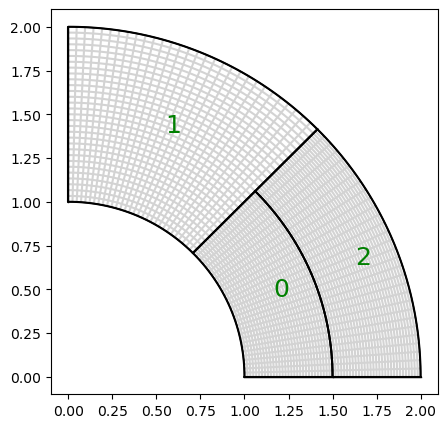

In [160]:
M.plotmesh(knots=True, patch_idx=True)

In [161]:
IMap = IetiMapper(M, dir_data)
IMap.parametersort(a)

In [162]:
A, RHS = IMap.assemble(a=a,f=f)
N = [A.shape[0] for A in A]
B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
    
SD = ScaledDirichletPreconditioner(A, B, IMap)

In [163]:
primal = PrimalSystem(IMap.nodes_as_primals())
A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
loc_solver = primal.compute_PrimalBasis(A, B, RHS)

In [164]:
A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim)
loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

I = IetiSystem(A, B, RHS, N, loc_solver)
F, b = I.SchurComplement(), I.RHSforSchurComplement()

In [165]:
SD.setupSelectionScaling()
lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=2000, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)

u = I.constructSolutionFromLagrangeMultipliers(lam)
u = IMap.completeDirichlet(u)

Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 7.737 stopped after 9 iterations with relres 1.666e-07 after 0.0744 seconds.


In [166]:
len(np.concatenate(u[:-1]))

4800

In [167]:
u,_,_ = solveIETI(M, dir_data,f,a)

Convergence condition: 0.0


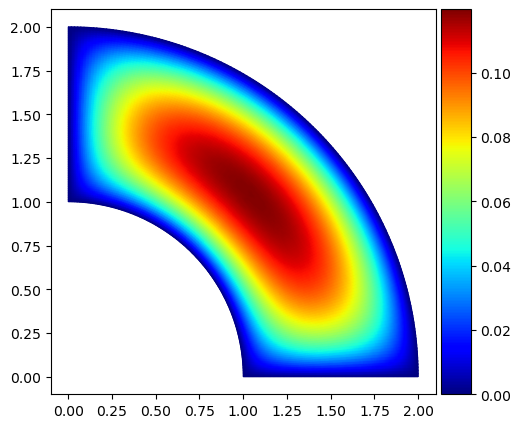

In [169]:
MP.plot(u);

# Checkerboard mesh with jumping coefficients (larger coefficient has coarser grid)

In [10]:
#degs = (2,3,4,5,6,7,8)
#maxiters=(6,6,6,5,5,4,4) ##<8

degs=(1,)
maxiters=(3,)
R1 = np.zeros((max(maxiters),2*len(degs)))
R2 = np.zeros((max(maxiters),2*len(degs)))

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1.}
dir_data = {0:0}

plot=False

for i, deg in enumerate(degs):
    N = deg+1
    knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
    M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
    M.h_refine()
    M.h_refine()
    M.set_domain_id({1:{0,1,2,3,6,9,12,15}})
    #M.h_refine({p:-1 for p in {0,1,2,3,6,9,12,15}})
    M.h_refine({p:-1 for p in {4,5,7,8,10,11,13,14}})

    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiters[i]):
        print("Iteration {}".format(k))
        if plot:
            M.plotmesh(figsize=(10,10),color={1:'white',0:'orange'}, knots=1, bwidth=3, nodes=1, bcolor={0:'blue'})
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig('/home/wolfman/Pictures/IETI-checkerboard/i'+str(k)+'.pdf',bbox_inches='tight')
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        t_IETI = 0
        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]

        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)
        I = IetiSystem(A, B, RHS, N)

        # A_full = I.SaddlePointSystem(format='csc')
        # RHS_full = I.RHSforSaddlePointSystem()
        # eps=1e-6

        # z = np.zeros(A_full.shape[0])
        # z[-B[0].shape[0]:]=eps
        # A_full += scipy.sparse.spdiags(z,0,*A_full.shape)
    
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        t=time.time()

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        t_IETI+=time.time()-t
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        t_IETI+=time.time()-t
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        t_IETI+=time.time()-t
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        t_IETI+=time.time()-t
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        SD.setupSelectionScaling()
        t_IETI+=time.time()-t
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)

        #t=time.time()
        #U = solvers.make_solver(A_full, symm=True)@RHS_full
        #print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R1[k,2*i] = it
        R1[k,2*i+1] = abs(max_eig/min_eig)

        # P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        # lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)
        # R2[k,2*i] = it
        # R2[k,2*i+1] = abs(max_eig/min_eig)
        
        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        t=time.time()
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate(IMap.completeDirichlet(u))
        t_IETI+=time.time()-t
        print("Computing full solution from skeleton took {:.3} seconds.".format(time.time()-t))
        print("Full time for the IETI-solver: {:.3} seconds".format(t_IETI))
        #print(len(u))
        #MP.plot(u)

        #err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        #marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        #marked_patches = {p:None for p in marked_patches}

        M.h_refine(-1);
        print("#####################################################")
#np.savetxt('checkerboard_badselection.txt', R1, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('checkerboard_badedge.txt', R2, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')

deg = 1
Iteration 0
Setting up IETI-mapper took 0.0839 seconds.
Assembling the system took 0.146 seconds.
Computing jump matrices took 0.000938 seconds.
Setting up primal system took 0.00196 seconds.
Setting up primal constraints took 0.0147 seconds.
Computing primal basis took 0.0208 seconds.
Setting up Schur complements took 0.00217 seconds.
Setting up selection scaling took 0.00346 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.799 stopped after 12 iterations with relres 5.056e-07 after 0.0343 seconds.
Computing full solution from skeleton took 0.00205 seconds.
Full time for the IETI-solver: 0.0451 seconds
#####################################################
Iteration 1
Setting up IETI-mapper took 0.0823 seconds.
Assembling the system took 0.141 seconds.
Computing jump matrices took 0.000998 seconds.
Setting up primal system took 0.00179 seconds.
Setting up primal constraints took 0.0135 seconds.
Computing primal basis took 0.0222 seconds.
Settin

# Checkerboard mesh with changing disparity level

setting up constraints took 0.03920102119445801 seconds.
Basis setup took 0.002452373504638672 seconds
deg = 1
Iteration 0


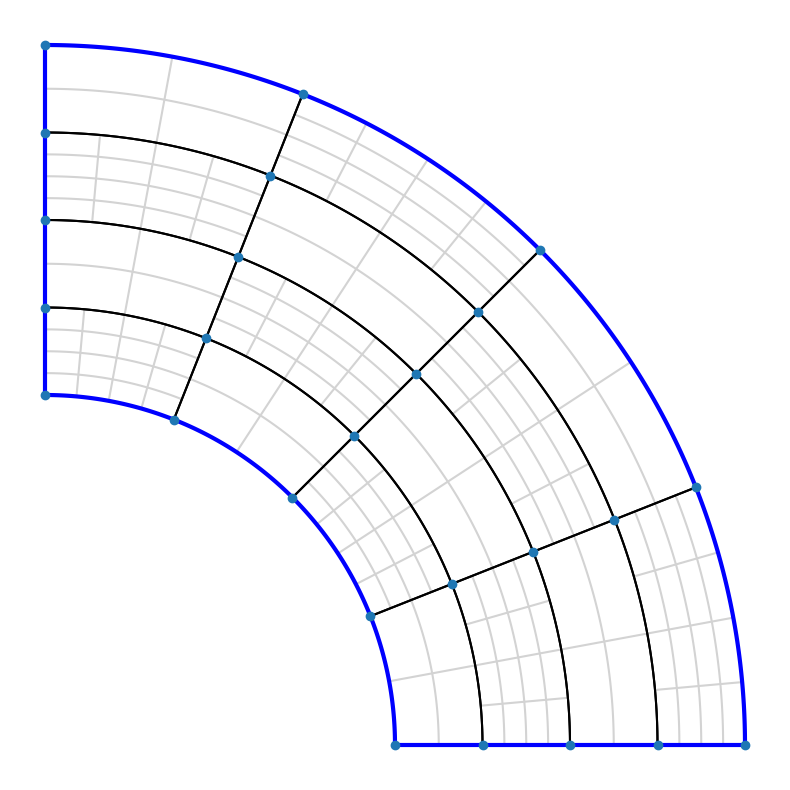

setting up constraints took 0.03192257881164551 seconds.
Basis setup took 0.002461671829223633 seconds
Setting up IETI-mapper took 0.0806 seconds.
Assembling the system took 0.162 seconds.
Computing jump matrices took 0.000993 seconds.
Setting up primal system took 0.00223 seconds.
Setting up primal constraints took 0.0139 seconds.
Computing primal basis took 0.0256 seconds.
Setting up Schur complements took 0.00231 seconds.
Setting up selection scaling took 0.00304 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.751 stopped after 11 iterations with relres 2.82e-07 after 0.0301 seconds.
pcg with preconditioned condition number κ ~ 4.161 stopped after 12 iterations with relres 3.445e-07 after 0.0311 seconds.
Computing full solution from skeleton took 0.00798 seconds.
Full time for the IETI-solver: 0.055 seconds
#####################################################
Iteration 1


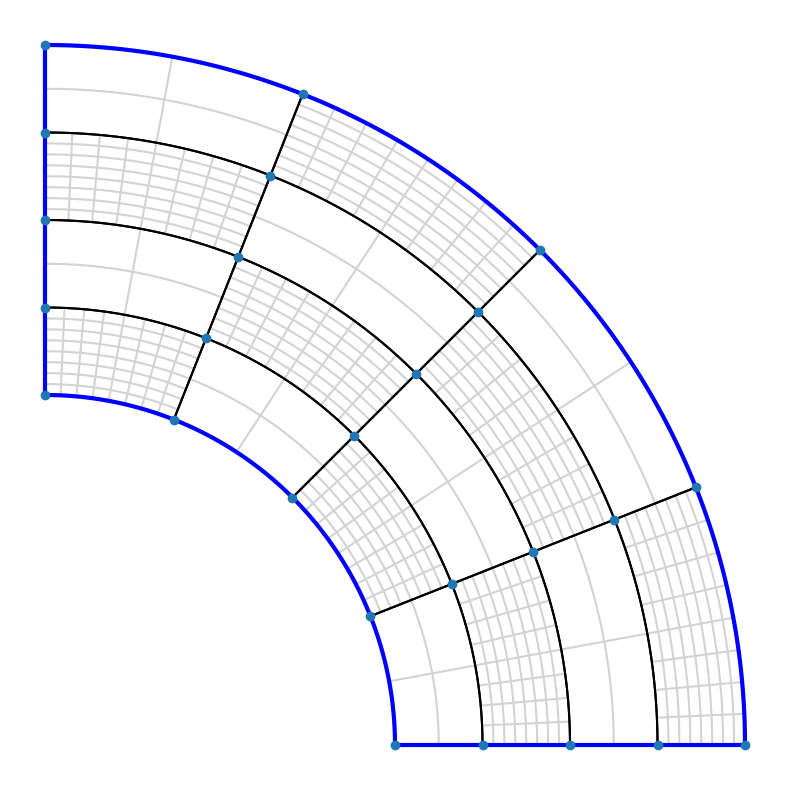

setting up constraints took 0.03147172927856445 seconds.
Basis setup took 0.0024449825286865234 seconds
Setting up IETI-mapper took 0.0714 seconds.
Assembling the system took 0.124 seconds.
Computing jump matrices took 0.00103 seconds.
Setting up primal system took 0.00185 seconds.
Setting up primal constraints took 0.0132 seconds.
Computing primal basis took 0.0212 seconds.
Setting up Schur complements took 0.00231 seconds.
Setting up selection scaling took 0.00292 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.826 stopped after 11 iterations with relres 3.561e-07 after 0.0313 seconds.
pcg with preconditioned condition number κ ~ 6.017 stopped after 14 iterations with relres 5.017e-07 after 0.0218 seconds.
Computing full solution from skeleton took 0.00283 seconds.
Full time for the IETI-solver: 0.0442 seconds
#####################################################
Iteration 2


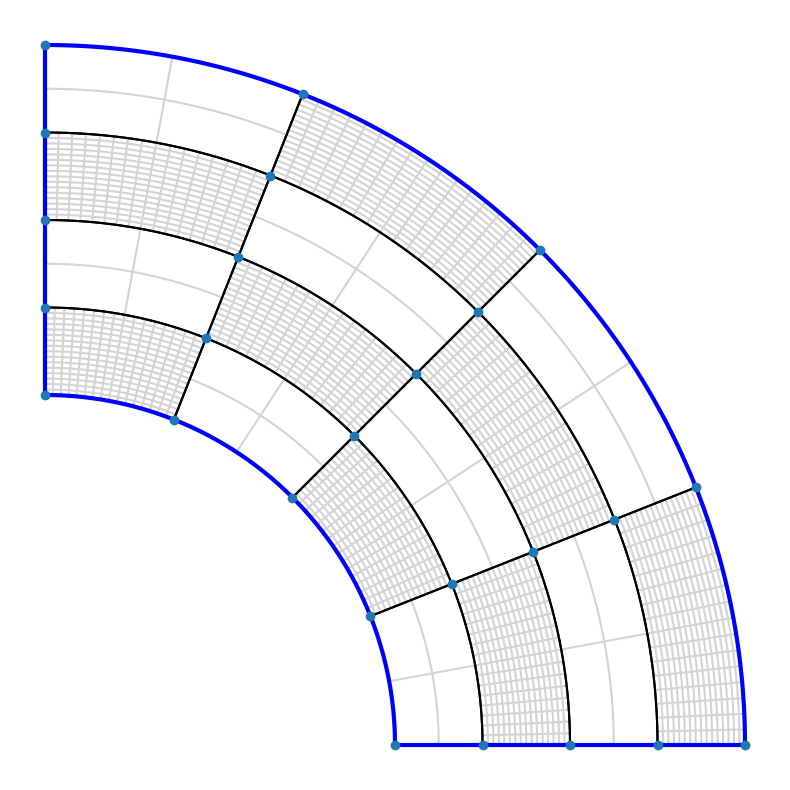

setting up constraints took 0.03246045112609863 seconds.
Basis setup took 0.002602815628051758 seconds
Setting up IETI-mapper took 0.0757 seconds.
Assembling the system took 0.14 seconds.
Computing jump matrices took 0.00114 seconds.
Setting up primal system took 0.00173 seconds.
Setting up primal constraints took 0.0135 seconds.
Computing primal basis took 0.0217 seconds.
Setting up Schur complements took 0.00229 seconds.
Setting up selection scaling took 0.0029 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.912 stopped after 11 iterations with relres 3.787e-07 after 0.0426 seconds.
pcg with preconditioned condition number κ ~ 8.516 stopped after 16 iterations with relres 7.439e-07 after 0.0313 seconds.
Computing full solution from skeleton took 0.0033 seconds.
Full time for the IETI-solver: 0.0454 seconds
#####################################################
Iteration 3


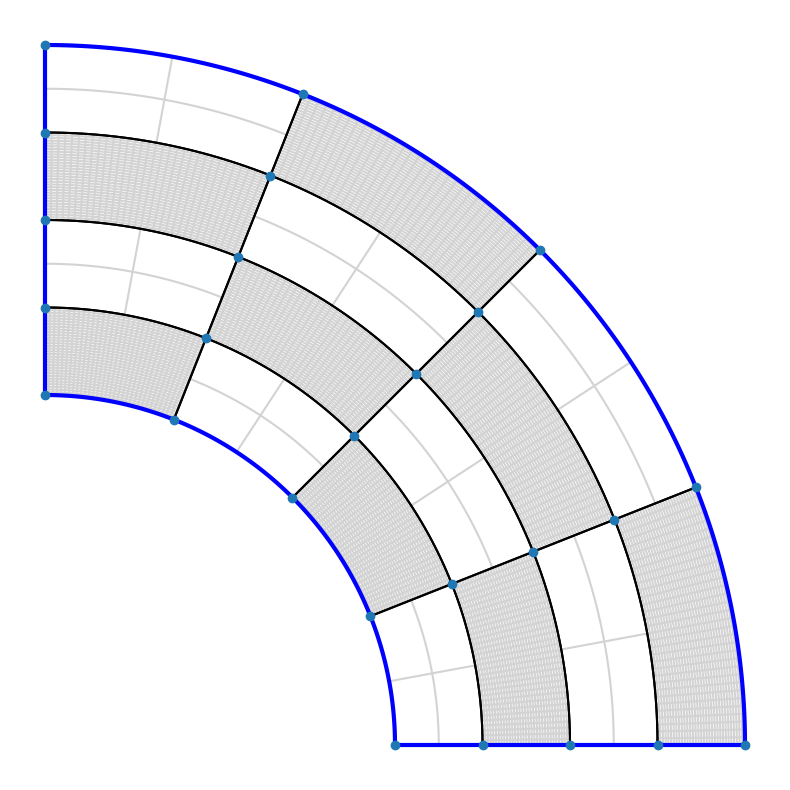

setting up constraints took 0.03747987747192383 seconds.
Basis setup took 0.0029823780059814453 seconds
Setting up IETI-mapper took 0.0807 seconds.
Assembling the system took 0.167 seconds.
Computing jump matrices took 0.00155 seconds.
Setting up primal system took 0.00198 seconds.
Setting up primal constraints took 0.0152 seconds.
Computing primal basis took 0.0327 seconds.
Setting up Schur complements took 0.00343 seconds.
Setting up selection scaling took 0.00315 seconds.
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 4.993 stopped after 11 iterations with relres 3.833e-07 after 0.0529 seconds.
pcg with preconditioned condition number κ ~ 11.85 stopped after 18 iterations with relres 5.696e-07 after 0.892 seconds.
Computing full solution from skeleton took 0.0621 seconds.
Full time for the IETI-solver: 0.119 seconds
#####################################################


In [43]:
degs = (2,3,4,5,6,7,8)
maxiters=(6,6,6,5,5,4,4) ##<8

degs=(1,)
maxiters=(4,)

R1 = np.zeros((max(maxiters),2*len(degs)))
R2 = np.zeros((max(maxiters),2*len(degs)))

f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1.}
dir_data = {0:0}

plot=True

for i, deg in enumerate(degs):
    N = deg+1
    knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
    M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
    M.h_refine()
    M.h_refine()
    M.set_domain_id({1:{0,1,2,3,6,9,12,15}})
    #M.h_refine({p:-1 for p in {0,1,2,3,6,9,12,15}})
    M.h_refine({p:-1 for p in M.domains[0]})

    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiters[i]):
        print("Iteration {}".format(k))
        if plot:
            M.plotmesh(figsize=(10,10),color={1:'white',0:'white'}, knots=1, bwidth=3, nodes=1, bcolor={0:'blue'})
            plt.axis('off');
            plt.axis('scaled');
            plt.savefig('/home/wolfman/Pictures/IETI-checkerboard/i'+str(k)+'.pdf',bbox_inches='tight')
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        t_IETI = 0
        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]

        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=True)
        I = IetiSystem(A, B, RHS, N)

        # A_full = I.SaddlePointSystem(format='csc')
        # RHS_full = I.RHSforSaddlePointSystem()
        # eps=1e-6

        # z = np.zeros(A_full.shape[0])
        # z[-B[0].shape[0]:]=eps
        # A_full += scipy.sparse.spdiags(z,0,*A_full.shape)
    
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        t=time.time()

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        t_IETI+=time.time()-t
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        t_IETI+=time.time()-t
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        t_IETI+=time.time()-t
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        t_IETI+=time.time()-t
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        SD.setupSelectionScaling()
        t_IETI+=time.time()-t
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)

        #t=time.time()
        #U = solvers.make_solver(A_full, symm=True)@RHS_full
        #print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R1[k,2*i] = it
        R1[k,2*i+1] = abs(max_eig/min_eig)

        P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=P, output=True, rtol=1e-6, atol=1e-12)
        R2[k,2*i] = it
        R2[k,2*i+1] = abs(max_eig/min_eig)
        
        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        t=time.time()
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        t_IETI+=time.time()-t
        print("Computing full solution from skeleton took {:.3} seconds.".format(time.time()-t))
        print("Full time for the IETI-solver: {:.3} seconds".format(t_IETI))
        #print(len(u))
        #MP.plot(u)

        #err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        #marked_patches = adaptive.doerfler_mark(err_ind, theta=0.9, TOL=0)
        #marked_patches = {p:None for p in marked_patches}

        #M.h_refine(-1);
        M.h_refine({p:-1 for p in {4,5,7,8,10,11,13,14}})
        print("#####################################################")
#np.savetxt('checkerboard_badselection.txt', R1, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')
#np.savetxt('checkerboard_badedge.txt', R2, fmt=len(degs)*('%d','%1.3f'), delimiter = ' & ', newline='\\\\\n')

In [34]:
def Heat_annulus(deg, N):
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.quarter_annulus(),
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)

    M.h_refine()

    M.set_domain_id({1:{0}})
    return M

In [8]:
f={0:lambda x,y: 100., 1:lambda x,y: 100.}
a = {0:1.,1:1000.}
dir_data = {0:0}

plot=True

degs = (3,)
maxiter=15
R = np.zeros((maxiter,3*len(degs)))
for i,deg in enumerate(degs):
    N = deg+1
    M = Heat_annulus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)

    print("======================================================")
    print("deg = "+str(deg))
    for k in range(maxiter):
        print(k)
        n_p = MP.nPatches
        if plot:
            M.draw(figsize=(5,5),color={1:'orange',0:'white'}, knots=1, bwidth=0.01, nodes=0)
            plt.axis('off');
            plt.axis('scaled');
            #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
            plt.show()

        MP = assemble.Multipatch(M, automatch=True)

        ### IETI Mapper
        t = time.time()
        IMap = IetiMapper(M, dir_data)
        IMap.parametersort(a)
        print("Setting up IETI-mapper took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, RHS = IMap.assemble(a=a,f=f)
        print("Assembling the system took {:.3} seconds.".format(time.time()-t))
        N = [A.shape[0] for A in A]
        t=time.time()
        B, eliminated_constraints = IMap.ConstraintMatrices(redundant=False)
        print("Computing jump matrices took {:.3} seconds.".format(time.time()-t))
        ### IETI Preconditioner
        SD = ScaledDirichletPreconditioner(A, B, IMap)

        ### Set up primal system
        t=time.time()
        primal = PrimalSystem(IMap.nodes_as_primals())
        print("Setting up primal system took {:.3} seconds.".format(time.time()-t))
        t=time.time()
        A, B, RHS, C = primal.incorporate_PrimalConstraints(A, B, RHS, IMap)
        print("Setting up primal constraints took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        loc_solver = primal.compute_PrimalBasis(A, B, RHS)
        print("Computing primal basis took {:.3} seconds.".format(time.time()-t))
        A.append(primal.A_prim), B.append(primal.B_prim), RHS.append(primal.RHS_prim), loc_solver.append(solvers.make_solver(primal.A_prim, spd=True, symm=True)), N.append(primal.A_prim.shape[0])

        ### Set up IETI Schur System and solve with CG
        I = IetiSystem(A, B, RHS, N, loc_solver)
        t=time.time()
        F, b = I.SchurComplement(), I.RHSforSchurComplement()
        print("Setting up Schur complements took {:.3} seconds.".format(time.time()-t))

        #lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=1, output=True, rtol=1e-6, atol=1e-12)

        t=time.time()
        SD.setupSelectionScaling(a=a)
        print("Setting up selection scaling took {:.3} seconds.".format(time.time()-t))
        #P = MsD_deluxe_whole(IMap, SD.SchurMatrices(), SD.B, C)
        #A_full = I.SaddlePointSystem(format='csc')
        #RHS_full = I.RHSforSaddlePointSystem()

        # t=time.time()
        # U = solvers.make_solver(A_full)@RHS_full
        # print("Solving full system took {:.3} seconds.".format(time.time()-t))
        
        lam, it, min_eig, max_eig, r = solvers.pcg(F, b, x0=None, maxiter=200, P=SD.prec(), output=True, rtol=1e-6, atol=1e-12)
        R[k,3*i] = n_p
        R[k,3*i+1] = abs(max_eig/min_eig)
        R[k,3*i+2] = it 

        ### Construct Solution from Lagrange Multiplier and complete with Dirichlet values
        u = primal.distributePrimalSolution(I.constructSolutionFromLagrangeMultipliers(lam))
        u = np.concatenate([IMap.BCRestr[p].complete(u) if p in IMap.BCRestr else u for p,u in enumerate(u)])
        #MP.plot(u)

        t=time.time()
        err_ind=adaptive.mp_resPois(MP,u,a=a, f=f)

        marked_patches = adaptive.quick_mark(err_ind, theta=0.9)
        marked_patches = {p:None for p in marked_patches}
        print("Estimating and marking took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)
        print("Patch-splitting took {:.3} seconds for {} patches".format(time.time()-t, len(marked_patches)))

        marked_patches = consistency_split(MP,a)
        #print(marked_patches)
        M.h_refine(patches=marked_patches,ref="rs");
        MP = assemble.Multipatch(M, automatch=True)

        print("#####################################################")

#np.savetxt('singular_selection_consistency', R, fmt=len(degs)*('%d', '%1.3f','%d'), delimiter = ' & ', newline='\\\\\n')

NameError: name 'Heat_annulus' is not defined

# Inductor example

In [21]:
def Inductor(deg,N, airgap=0.025):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,airgap)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,airgap)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,airgap)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,airgap)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.25+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.25+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.25+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.25+airgap)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.75+airgap)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.75+airgap)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.75+airgap)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.75+airgap)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.0+airgap)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.0+airgap)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.0+airgap)),
        geometry.unit_square().scale(0.5).translate((1.5,1.0+airgap)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    #M.h_refine({i:1 for i in range(14,21)});                          #split airgap patches further in y-axis to make up for anisotropy 
    #M.h_refine({i:1 for i in list(range(14,21))+list(range(42,49))}); #split airgap patches further in y-axis to make up for anisotropy 
    return M

In [34]:
mu0 = 4*np.pi*1e-7
#nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
nu = {'C1': 1., 'C2':1., 'Fe':0.1, 'Air': 1.}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
#j = {'C1': lambda x,y: 1.0, 'C2':lambda x,y: 1.0, 'Fe':lambda x,y: 1.0, 'Air': lambda x,y: 1.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}
dir_data = {0:0}

setting up constraints took 0.08243918418884277 seconds.
Basis setup took 0.0024673938751220703 seconds
deg = 4
Number of patches: 42
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.44 stopped after 19 iterations with relres 7.723e-07 after 0.14 seconds.
Error Estimator: 7.52
Estimating and marking took 0.63 seconds.
Refinement took 0.03280973434448242 seconds for 6 patches.
Prolongation took 0.037474632263183594 seconds
Split 6 patches due to error indicator
Refinement took 0.04532027244567871 seconds for 7 patches.
Prolongation took 0.04417252540588379 seconds
Split 9 additional patches due to consistency
Split 0 additional patches due to admissibility
Patch-splitting took 0.232 seconds
setting up constraints took 0.19758343696594238 seconds.
Basis setup took 0.004559755325317383 seconds
#####################################################
Number of patches: 81
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 11.38 stopped after 22 i

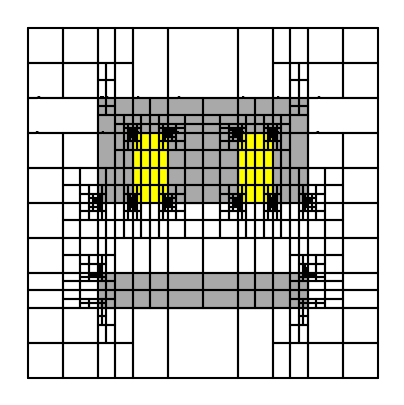

In [35]:
degs = (4,)
maxpatches =1000
n_info=6
R = np.zeros((100,n_info*len(degs)))
maxiter=0

for i,deg in enumerate(degs):
    N = deg + 1
    M = Inductor(deg,N, airgap=0.5)
    MP = assemble.Multipatch(M, automatch=True)
    U = []

    print("======================================================")
    print("deg = "+str(deg))
    k=0
    while MP.nPatches < maxpatches:
        #M.plotmesh(figsize=(5,5),color={'C1':'yellow', 'C2':'yellow', 'Fe':'darkgrey', 'Air':'white'}, knots=0, bwidth=0.01, patch_idx=0)
        #plt.axis('off');
        #plt.axis('scaled');
        #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        #plt.show()
        
        print("Number of patches: {}".format(MP.nPatches))
        R[k,n_info*i]=MP.nPatches
        R[k,n_info*i+1]=MP.N_ofs[-1]
        
        ### Solve
        u,R[k,n_info*i+2],R[k,n_info*i+3]  = solveIETI(M,dir_data,j,nu)
        U.append(u)

        t=time.time()
        err_ind=adaptive.mp_resPois(MP,u,a=nu, f=j, M=MaT)
        eta = np.linalg.norm(err_ind)

        R[k,n_info*i+4]=eta
        #R[k,6*i+5]=u_err

        print("Error Estimator: {:.3}".format(eta))

        marked_patches = adaptive.doerfler_mark(err_ind, theta=0.8, TOL = 0.05)
        marked_patches = {p:None for p in marked_patches}
        print("Estimating and marking took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        P=MP.h_refine(h_ref=marked_patches,ref="rs", return_P = True, decoupled=True)
        print("Split {} patches due to error indicator".format(len(marked_patches)))
        P = consistency_split(MP,nu,return_P =True)@P;
        P = admissibility_split(MP, return_P = True)@P;
        print("Patch-splitting took {:.3} seconds".format(time.time()-t))
        MP = assemble.Multipatch(M, automatch=True)

        U=[P@u for u in U]

        k+=1
        print("#####################################################")
    P = MP.h_refine(h_ref=-1, return_P = True, decoupled=True)
    P = MP.p_refine(1, return_P=True, decoupled=True)@P
    u_exact,_,_  = solveIETI(M,dir_data,j,nu)
    A = sum([MP.assemble_volume("nu * inner(grad(u),grad(v)) * dx", arity=2, nu=nu[key], decoupled=True) for key in MP.mesh.domains])
    for l in range(k):
        e = P@U[l]-u_exact
        R[l,n_info*i+5] = e.T@A@e

    
    maxiter=max(k,maxiter)

R = R[:maxiter,:]
M.plotmesh(figsize=(5,5),color={'C1':'yellow', 'C2':'yellow', 'Fe':'darkgrey', 'Air':'white'}, knots=0, bwidth=0.01, patch_idx=0)
plt.axis('off');
plt.axis('scaled');
#plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
plt.show()

In [36]:
R

array([[4.20000e+01, 3.40200e+03, 1.14372e+01, 1.90000e+01, 7.51974e+00, 5.21915e+01],
       [8.10000e+01, 6.56100e+03, 1.13762e+01, 2.20000e+01, 4.41674e+00, 3.54081e+01],
       [1.50000e+02, 1.21500e+04, 1.28988e+01, 2.40000e+01, 2.91821e+00, 1.84115e+01],
       [2.40000e+02, 1.94400e+04, 1.33477e+01, 2.40000e+01, 2.07088e+00, 1.44815e+01],
       [3.42000e+02, 2.77020e+04, 1.34367e+01, 2.40000e+01, 1.34530e+00, 5.54111e+00],
       [4.62000e+02, 3.74220e+04, 1.34223e+01, 2.40000e+01, 9.07134e-01, 2.04401e+00],
       [6.00000e+02, 4.86000e+04, 1.34237e+01, 2.40000e+01, 5.61019e-01, 7.88235e-01],
       [7.62000e+02, 6.17220e+04, 1.38032e+01, 2.40000e+01, 3.45860e-01, 2.82083e-01],
       [9.06000e+02, 7.33860e+04, 1.34599e+01, 2.40000e+01, 2.21303e-01, 1.06659e-01]])

In [88]:
def QuarterAnullus(deg, N):
    patches = [(2*(bspline.make_knots(2,0,1,5),),geometry.quarter_annulus())]
    M = topology.PatchMesh(patches)
    M.h_refine();
    M.set_domain_id({1:{0}})
    return M

In [89]:
j = {0:lambda x,y: 1.0, 1:lambda x,y:1.0}
nu = {0:100000.0, 1:1.0}
dir_data = {0:0}

setting up constraints took 0.013451337814331055 seconds.
Basis setup took 0.003610849380493164 seconds
deg = 2
Number of patches: 4
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 3.062 stopped after 4 iterations with relres 4.598e-07 after 0.00421 seconds.
Error Estimator: 0.00768
Estimating and marking took 0.0575 seconds.
Refinement took 0.011326074600219727 seconds for 3 patches.
Prolongation took 0.018662691116333008 seconds
Split 3 patches due to error indicator
Split 0 additional patches due to consistency
Split 0 additional patches due to admissibility
Patch-splitting took 0.0434 seconds
setting up constraints took 0.02255415916442871 seconds.
Basis setup took 0.0018229484558105469 seconds
#####################################################
Number of patches: 13
Convergence condition: 0.0
pcg with preconditioned condition number κ ~ 8.799 stopped after 13 iterations with relres 1.187e-07 after 0.0306 seconds.
Error Estimator: 0.00396
Estimating and ma

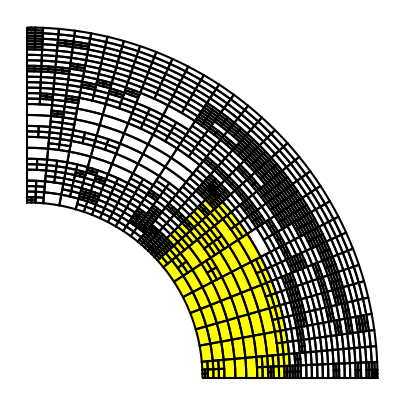

In [99]:
degs = (2,)
maxpatches =700
n_info=6
R = np.zeros((100,n_info*len(degs)))
maxiter=0

for i,deg in enumerate(degs):
    N = deg + 1
    M = QuarterAnullus(deg,N)
    MP = assemble.Multipatch(M, automatch=True)
    U = []

    print("======================================================")
    print("deg = "+str(deg))
    k=0
    while MP.nPatches < maxpatches:
        #M.plotmesh(figsize=(5,5),color={'C1':'yellow', 'C2':'yellow', 'Fe':'darkgrey', 'Air':'white'}, knots=0, bwidth=0.01, patch_idx=0)
        #plt.axis('off');
        #plt.axis('scaled');
        #plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
        #plt.show()
        
        print("Number of patches: {}".format(MP.nPatches))
        R[k,n_info*i]=MP.nPatches
        R[k,n_info*i+1]=MP.N_ofs[-1]
        
        ### Solve
        u,R[k,n_info*i+2],R[k,n_info*i+3]  = solveIETI(M,dir_data,j,nu)
        U.append(u)

        t=time.time()
        err_ind=adaptive.mp_resPois(MP,u,a=nu, f=j)
        eta = np.linalg.norm(err_ind)

        R[k,n_info*i+4]=eta
        #R[k,6*i+5]=u_err

        print("Error Estimator: {:.3}".format(eta))

        marked_patches = adaptive.doerfler_mark(err_ind, theta=0.8, TOL = 0.05)
        marked_patches = {p:None for p in marked_patches}
        print("Estimating and marking took {:.3} seconds.".format(time.time()-t))

        t=time.time()
        P=MP.h_refine(h_ref=marked_patches,ref="rs", return_P = True, decoupled=True)
        print("Split {} patches due to error indicator".format(len(marked_patches)))
        P = consistency_split(MP,nu,return_P =True)@P;
        P = admissibility_split(MP, return_P = True)@P;
        print("Patch-splitting took {:.3} seconds".format(time.time()-t))
        MP = assemble.Multipatch(M, automatch=True)

        U=[P@u for u in U]

        k+=1
        print("#####################################################")
    #P = MP.h_refine(h_ref=-1, return_P = True, decoupled=True)
    P = MP.p_refine(2, return_P=True, decoupled=True)
    u_exact,_,_  = solveIETI(M,dir_data,j,nu)
    A = sum([MP.assemble_volume("nu * inner(grad(u),grad(v)) * dx", arity=2, nu=nu[key], decoupled=True) for key in MP.mesh.domains])
    for l in range(k):
        e = P@U[l]-u_exact
        R[l,n_info*i+5] = e.T@A@e

    
    maxiter=max(k,maxiter)

R = R[:maxiter,:]
M.plotmesh(figsize=(5,5),color={0:'white', 1:'yellow'}, knots=0, bwidth=0.01, patch_idx=0)
plt.axis('off');
plt.axis('scaled');
#plt.savefig('/home/wolfman/Pictures/Inductor/p'+str(deg)+'/i'+str(i)+'.pdf',bbox_inches='tight');
plt.show()

In [100]:
R

array([[4.00000e+00, 1.96000e+02, 3.06238e+00, 4.00000e+00, 7.68204e-03, 6.87600e-01],
       [1.30000e+01, 6.37000e+02, 8.79930e+00, 1.30000e+01, 3.96497e-03, 5.63528e-02],
       [2.20000e+01, 1.07800e+03, 8.87111e+00, 1.80000e+01, 2.16216e-03, 3.25726e-02],
       [4.90000e+01, 2.40100e+03, 1.01542e+01, 2.00000e+01, 1.08912e-03, 8.10661e-03],
       [7.00000e+01, 3.43000e+03, 1.02181e+01, 2.00000e+01, 5.38326e-04, 2.78560e-03],
       [1.06000e+02, 5.19400e+03, 1.05405e+01, 2.10000e+01, 2.91601e-04, 1.51418e-03],
       [1.75000e+02, 8.57500e+03, 1.08580e+01, 2.20000e+01, 1.35403e-04, 7.57061e-04],
       [3.34000e+02, 1.63660e+04, 1.19929e+01, 2.20000e+01, 8.88527e-05, 1.31410e-04],
       [6.19000e+02, 3.03310e+04, 1.32128e+01, 2.30000e+01, 6.33793e-05, 5.76265e-05]])

In [60]:
M = Inductor(2,3)

In [63]:
M.patches[0][0]

((KnotVector(array([0.     , 0.     , 0.     , 0.33333, 0.66667, 1.     , 1.     , 1.     ]), 2),
  KnotVector(array([0.     , 0.     , 0.     , 0.33333, 0.66667, 1.     , 1.     , 1.     ]), 2)),
 <pyiga.bspline.BSplineFunc at 0x7f99f85a2030>)